# Twitter Bot URL: https://twitter.com/TheSentimentBot

In [207]:
import tweepy
import pandas as pd
import time
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from dummy_config import (consumer_key, consumer_secret, access_token, access_secret)
from pprint import pprint
from pylab import savefig
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [215]:
def posted_tweets(): #returns list of already posted tweets
    already_responded = []
    for status in tweepy.Cursor(api.user_timeline, id='@BotSentimental', type='recent').items():
        already_responded.append(status._json.get('text'))
    return already_responded

In [216]:
# this chops the list of previously tweeted things to return list of names of analyzed accounts
def analyzed_accounts():
    tweets = posted_tweets()
    accounts = [tweet.split(" ")[5] for tweet in tweets if 'Sentiment' in tweet]
    return accounts

In [217]:
def plot_analysis(account): # the input account is the account to be analyzed
    results = []
    for status in tweepy.Cursor(api.user_timeline, screen_name = account).items(500):
        tweet = status._json.get('text')
        results.append(analyzer.polarity_scores(tweet).get('compound'))
    tweets_ago = list(range(len(results)))
    sns.set_style('dark')
    plt.plot(tweets_ago, results, color = 'firebrick', marker = 'o', linewidth=0.2, alpha=0.7)
    plt.gca().invert_xaxis()
    plt.xticks(np.arange(min(tweets_ago), max(tweets_ago)+2, 100))
    plt.xlabel('How Many Tweets Ago')
    plt.ylabel('Sentiment Score')
    plt.title(f'Previous 500 Tweets from {account}')
    savefig(f'{account}.png')
    

In [229]:
def tweet_back(incoming_tweet, tweet_id, screen_name_tweeter): 
    #checks the format, if the account was analyzed, then tweets out response
    tweet_split = incoming_tweet.split(" ")
    if len(tweet_split) == 4:
        account_ask = tweet_split[3]
        if not('Please analyze:' in incoming_tweet) and not('please analyze:' in incoming_tweet):
            if ('Please' in incoming_tweet) | ('please' in incoming_tweet):
                api.update_status(f"@{screen_name_tweeter} You didn't use the correct format!", tweet_id)
            else:
                api.update_status(f"@{screen_name_tweeter} You didn't say please!", tweet_id)
        else:
            try:
                accounts_analyzed = analyzed_accounts()
                for each in accounts_analyzed:
                    if each == account_ask:
                        api.update_status(f"@{screen_name_tweeter} I've already analyzed that account!", tweet_id)
                        return "completed"
                plot_analysis(account_ask)
                api.update_with_media(filename = f'{account_ask}.png', status= f"@{screen_name_tweeter} Sentiment analysis of tweets from {account_ask}. Thanks for your request!", in_reply_to_status_id = tweet_id)
            except IndexError:
                api.update_status(f"@{screen_name_tweeter} You didn't use the correct format!", tweet_id)
    else:
           api.update_status(f"@{screen_name_tweeter} You didn't use the correct format!", tweet_id)
            
    return "completed"        

In [223]:
def should_i_respond(incoming_tweet_id): # returns a boolean to indicate whether or not 
    #a tweet id has been responded to, and therefore the bot should respond
    tweet_responses = []
    for status in tweepy.Cursor(api.user_timeline).items():
        tweet_responses.append(status._json.get('in_reply_to_status_id'))
    
    for each in tweet_responses:
        if each == incoming_tweet_id:
            return False
    return True

KeyboardInterrupt: 

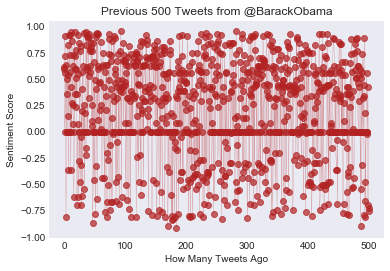

In [230]:
while True:
    for status in tweepy.Cursor(api.mentions_timeline).items():
        incoming_tweet = status._json.get('text')
        current_tweet_id = status._json.get('id')
        tweeter_sn = status._json.get('user').get('screen_name')
        
        response = should_i_respond(current_tweet_id)
        if response:
            tweet_back(incoming_tweet, current_tweet_id, tweeter_sn)    
    time.sleep(30)
    